<a href="https://colab.research.google.com/github/shiqisim/Final-Project/blob/main/resNet_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#5. Preparing your data

In [1]:
pip install scikit-learn==1.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 41.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
import numpy as np
import pandas as pd

# mount gdrive, required for downloaded dataset (or sql data dump)
import os
from google.colab import drive
drive.mount("/content/drive")

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow import keras
import cv2
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import LSTM,Bidirectional,Reshape
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))



Mounted at /content/drive
No GPU, using /device:CPU:0.


In [3]:
# project name
os.environ["PROJECT_NAME"] = "breast-cancer"

# set folder paths in gdrive for the coursework
os.environ["CODER_HOME"] = "/content"
os.environ["PROJECTS"] = os.getenv("CODER_HOME") + "/project"
os.environ["PROJECT_HOME"] = os.getenv("PROJECTS") + "/" + os.getenv("PROJECT_NAME")
os.environ["DATA_PATH"] = os.getenv("PROJECT_HOME") + "/data"
os.environ["SCRIPT_PATH"] = os.getenv("PROJECT_HOME") + "/scripts"

# heirachically create project folders in local if not exist
!mkdir -p $CODER_HOME
!mkdir -p $PROJECTS
!mkdir -p $PROJECT_HOME
!mkdir -p $DATA_PATH
!mkdir -p $SCRIPT_PATH

# set folder paths on gdrive for the coursework
os.environ["GD_COURSE_HOME"] = "/content/drive/MyDrive/data"
os.environ["GD_PROJECT_HOME"] = os.getenv("GD_COURSE_HOME") + "/" + os.getenv("PROJECT_NAME")
os.environ["GD_DATA_PATH"] = os.getenv("GD_PROJECT_HOME") + "/data"
os.environ["GD_SCRIPT_PATH"] = os.getenv("GD_PROJECT_HOME") + "/scripts"

# heirachically create project folders in gdrive if not exist
!mkdir -p $GD_COURSE_HOME
!mkdir -p $GD_PROJECT_HOME
!mkdir -p $GD_DATA_PATH
!mkdir -p $GD_SCRIPT_PATH

In [4]:
!ls -d $PROJECT_HOME/*

/content/project/breast-cancer/data  /content/project/breast-cancer/scripts


In [5]:
filePath = "/content/drive/MyDrive/data/breast-cancer/Dataset_BUSI_with_GT"
dirList = [os.path.join(filePath,i) for i in os.listdir(filePath)]
size_dict = {}
for i,value in enumerate(dirList):
    size_dict[os.listdir(filePath)[i]] = len(os.listdir(value))
size_dict


{'normal': 266, 'malignant': 421, 'benign': 891}

In [6]:
df = pd.DataFrame(os.listdir(dirList[0]))
print(df.info)

<bound method DataFrame.info of                          0
0          normal (10).png
1    normal (100)_mask.png
2    normal (102)_mask.png
3           normal (1).png
4         normal (100).png
..                     ...
261        normal (99).png
262         normal (9).png
263   normal (93)_mask.png
264   normal (91)_mask.png
265        normal (97).png

[266 rows x 1 columns]>


In [7]:
df = pd.DataFrame(os.listdir(dirList[1]))
print(df.info)

<bound method DataFrame.info of                            0
0          malignant (1).png
1         malignant (10).png
2    malignant (10)_mask.png
3     malignant (1)_mask.png
4        malignant (109).png
..                       ...
416       malignant (99).png
417       malignant (97).png
418  malignant (95)_mask.png
419       malignant (95).png
420       malignant (96).png

[421 rows x 1 columns]>


In [8]:
df = pd.DataFrame(os.listdir(dirList[2]))
print(df.info)

<bound method DataFrame.info of                           0
0            benign (1).png
1     benign (105)_mask.png
2          benign (105).png
3     benign (100)_mask.png
4     benign (104)_mask.png
..                      ...
886  benign (98)_mask_1.png
887    benign (98)_mask.png
888    benign (94)_mask.png
889         benign (95).png
890    benign (95)_mask.png

[891 rows x 1 columns]>


In [9]:
img_size = 150
img_channel = 3
X_benign , Xm_benign , y_benign = np.zeros((446,img_size,img_size,img_channel)) , np.zeros((446,img_size,img_size,img_channel)) , np.full(446,'benign')
X_normal , Xm_normal , y_normal = np.zeros((133,img_size,img_size,img_channel)) , np.zeros((133,img_size,img_size,img_channel)) , np.full(133,'normal')
X_malignant , Xm_malignant , y_malignant = np.zeros((210,img_size,img_size,img_channel)) , np.zeros((210,img_size,img_size,img_channel)) , np.full(210,'malignant')

In [10]:
img1_path = os.path.join(os.path.join(filePath,'benign'),os.listdir(os.path.join(filePath,'benign'))[1])

pil_img = load_img(img1_path,color_mode = 'rgb',target_size=(img_size,img_size))
img = img_to_array(pil_img)
img_shape = img.shape
print(img_shape)

def img_num(filename):

    val = 0

    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break

    return val

for tumor_path in dirList :
    for image in os.listdir(tumor_path) :
        p = os.path.join(tumor_path, image)
        # load image as to be grayscale and resize image
        pil_img = load_img(p,color_mode = 'rgb',target_size=(img_size,img_size))
        if image[-5] == ')' :                                   #if real image

            if image[0] == 'b' :
              # If image is correct, append it to X to be either benign, normal or malignant
                X_benign[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'n' :
                X_normal[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                X_malignant[img_num(image)-1]+= img_to_array(pil_img)
        #load masked image if not correct
        else :
          # add masked image to y
            if image[0] == 'b' :
                Xm_benign[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'n' :
                Xm_normal[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                Xm_malignant[img_num(image)-1]+= img_to_array(pil_img)

(150, 150, 3)


In [11]:
# concatenate the different layers: malignant, benign and normal
X = np.concatenate((X_benign, X_normal, X_malignant), axis = 0)
Xm = np.concatenate((Xm_benign, Xm_normal, Xm_malignant), axis = 0)
y = np.concatenate((y_benign, y_normal, y_malignant), axis = 0)

print(X.shape)
print(Xm.shape)
print(y.shape)
X /= 255.0
Xm /= 255.0

print(X.max())
print(Xm.min())

(789, 150, 150, 3)
(789, 150, 150, 3)
(789,)
1.0
0.0


In [12]:
# convert categorical to numerical data
encoder  = OneHotEncoder()

y=encoder.fit_transform(y.reshape(y.shape[0],1))

# splitting into test and training set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,shuffle=True,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42,stratify = y_train.toarray())
Xm_train,Xm_test,ym_train,ym_test = train_test_split(Xm,y,test_size = 0.2,shuffle=True,random_state=42,stratify=y.toarray())
Xm_train,Xm_val,ym_train,ym_val = train_test_split(Xm_train,ym_train,test_size=0.2,random_state=42,stratify = ym_train.toarray())

class_list = encoder.categories_
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(504, 150, 150, 3) (158, 150, 150, 3)
(504, 3) (158, 3)


In [13]:
base_model = tf.keras.applications.ResNet50(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=img_shape,
                pooling=None,
            )
for layer in base_model.layers:
    layer.trainable = False

X_feat_out = base_model.output
X_feat_flatten = Flatten()(X_feat_out)

X_feat_model = Model(inputs = base_model.input,outputs = X_feat_flatten)
X_feat_train = X_feat_model.predict(X_train)
X_feat_val = X_feat_model.predict(X_val)
X_feat_test = X_feat_model.predict(X_test)

Xm_feat_train = X_feat_model.predict(Xm_train)
Xm_feat_val = X_feat_model.predict(Xm_val)
Xm_feat_test = X_feat_model.predict(Xm_test)

5/5 [==============================] - 15s 3s/step


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import LSTM,Bidirectional,Reshape
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,confusion_matrix

In [15]:
df = pd.DataFrame(columns = ['classifier',"Precision", "recall", "f1_measure", "confusionMatrix", "train_accuracy","val_accuracy","test_accuracy"])

In [16]:
def eval(classifier_name,y_train,y_train_pred,y_val,y_val_pred,y_true,y_pred):
    y_train = np.argmax(y_train,axis=1)
    y_val = np.argmax(y_val,axis=1)
    y_true = np.argmax(y_true,axis=1)

    train_accuracy = round(accuracy_score(y_train,y_train_pred),4)
    val_accuracy = round(accuracy_score(y_val,y_val_pred),4)
    test_accuracy = round(accuracy_score(y_true,y_pred),4)
    f1_measure = round(f1_score(y_true,y_pred,average='weighted'),4)
    recall = round(recall_score(y_true,y_pred,average='weighted'),4)
    precision = round(precision_score(y_true,y_pred,average='weighted'),4)
    confusionMatrix = confusion_matrix(y_true,y_pred)

    score = {"classifier":classifier_name,"precision: ":precision,"recall: ":recall, "f1_measure: ":f1_measure, "confusionMatrix: ":confusionMatrix, "train_accuracy: ":train_accuracy, "val_accuracy: ":val_accuracy,"test_accuracy: ":test_accuracy}

    df.loc[len(df.index)] = score.values()
    for e,a in score.items():
        print(e,a)
    print("--"*20)

In [17]:
def classifier_eval(classifier,classifier_name,X_train,y_train,X_val,y_val,X_test,y_test):

    classifier.fit(X_train,np.argmax(y_train,axis=1))

    y_train_pred = classifier.predict(X_train)
    y_val_pred = classifier.predict(X_val)
    y_test_pred = classifier.predict(X_test)

    eval(classifier_name,y_train,y_train_pred,y_val,y_val_pred,y_test,y_test_pred)

In [18]:
names = ['SVM',
    'KNN',
    'ANN'
        ]

classifier = [
    SVC(),
    KNeighborsClassifier(),
    MLPClassifier(max_iter = 400),
]

cls_list = zip(names,classifier)
clsm_list = zip(names,classifier)

In [19]:
for n,c in cls_list:
    classifier_eval(c,n,X_feat_train,y_train.toarray(),X_feat_val,y_val.toarray(),X_feat_test,y_test.toarray())

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classifier SVM
precision:  0.2963
recall:  0.5443
f1_measure:  0.3837
confusionMatrix:  [[86  0  0]
 [48  0  0]
 [24  0  0]]
train_accuracy:  0.5714
val_accuracy:  0.5669
test_accuracy:  0.5443
----------------------------------------
classifier KNN
precision:  0.6108
recall:  0.6203
f1_measure:  0.6129
confusionMatrix:  [[62 19  5]
 [15 29  4]
 [13  4  7]]
train_accuracy:  0.8115
val_accuracy:  0.622
test_accuracy:  0.6203
----------------------------------------
classifier ANN
precision:  0.6947
recall:  0.6772
f1_measure:  0.6814
confusionMatrix:  [[57 18 11]
 [ 7 36  5]
 [ 9  1 14]]
train_accuracy:  0.7798
val_accuracy:  0.6063
test_accuracy:  0.6772
----------------------------------------


In [20]:
def resnet():

    model = Sequential()
    model.add(base_model)

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

    return model

In [21]:
from sklearn.metrics import f1_score,roc_auc_score,cohen_kappa_score
def evaluation(model,X_train,y_train,X_val,y_val,X_test,y_test,history):
    train_loss , train_acc = model.evaluate(X_train,y_train.toarray())
    val_loss, val_acc = model.evaluate(X_val,y_val.toarray())
    test_loss_value , test_accuracy = model.evaluate(X_test, y_test.toarray())
    y_pred = model.predict(X_test)
    y_pred_label = np.argmax(y_pred,axis=1)
    y_true_label = np.argmax(y_test,axis=1)
    f1_measure = f1_score(y_true_label,y_pred_label,average='weighted')
    roc_score = roc_auc_score(y_test.toarray(),y_pred)

    print("Train accuracy = "+str(train_acc))
    print("Validation accuracy = "+str(val_acc))
    print('Test accuracy = ' + str(test_accuracy))
    print("f1_measure = "+str(f1_measure))
    print("roc_area = "+str(roc_score))

In [22]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()

In [23]:
def fit_evaluate(model,X_train,y_train,X_test,y_test,bs,Epochs,patience):
    es = EarlyStopping(monitor='val_loss', mode='min', patience=patience,restore_best_weights=True, verbose=1)
    X1_train,X_val,y1_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42,stratify = y_train.toarray())
    history = model.fit(X1_train,y1_train.toarray(),batch_size = bs,epochs=Epochs,validation_data = (X_val,y_val.toarray()), callbacks=[es])
    evaluation(model,X1_train,y1_train,X_val,y_val,X_test,y_test,history)
    Train_Val_Plot(history.history['acc'],history.history['val_acc'],history.history['loss'],history.history['val_loss'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 51200)            204800    
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                      

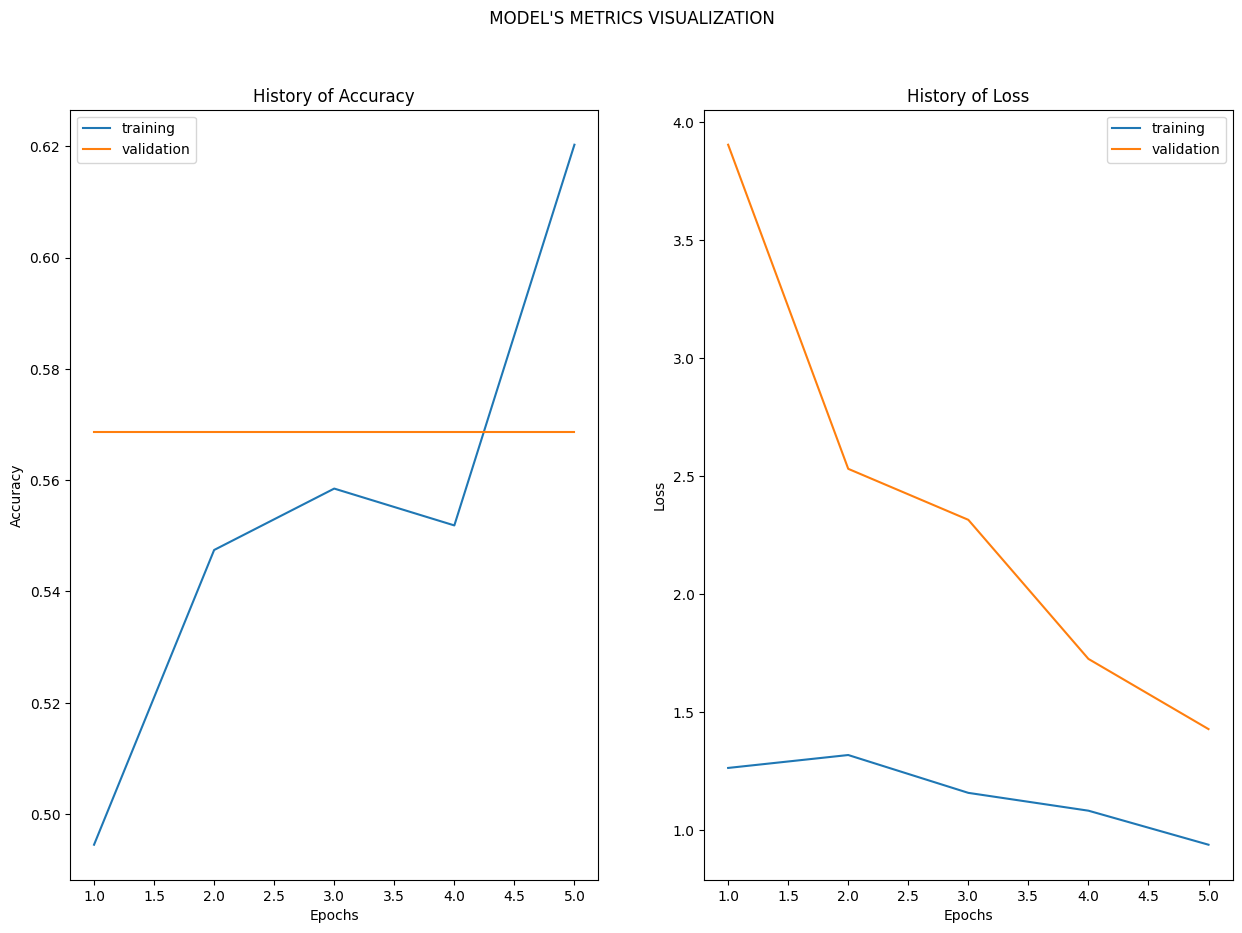

In [25]:
model = resnet()
model.summary()
fit_evaluate(model,X_train,y_train,X_test,y_test,16,5,4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 batch_normalization (BatchN  (None, 51200)            204800    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

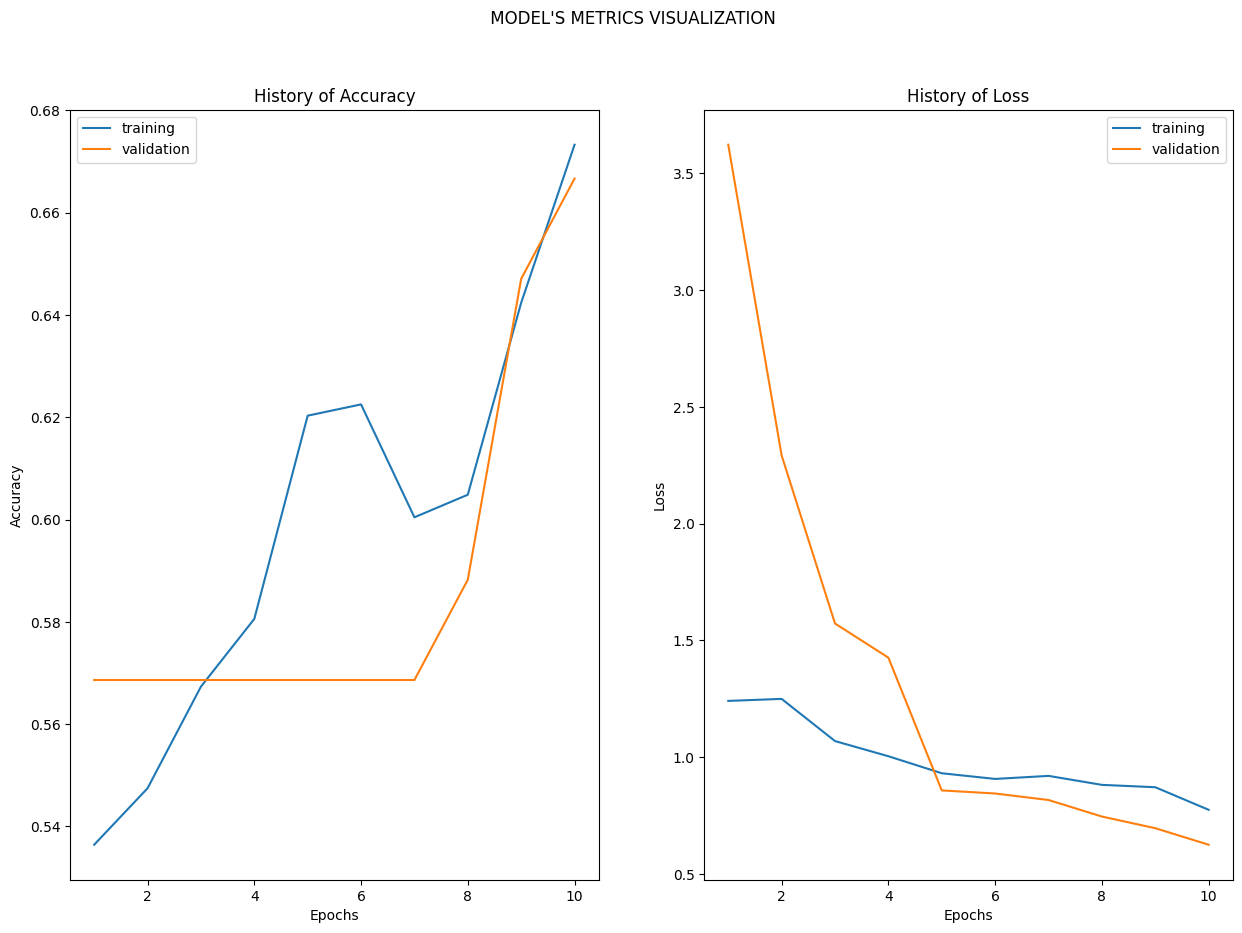

In [ ]:
model = resnet()
model.summary()
fit_evaluate(model,X_train,y_train,X_test,y_test,16,10,4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 batch_normalization (BatchN  (None, 51200)            204800    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

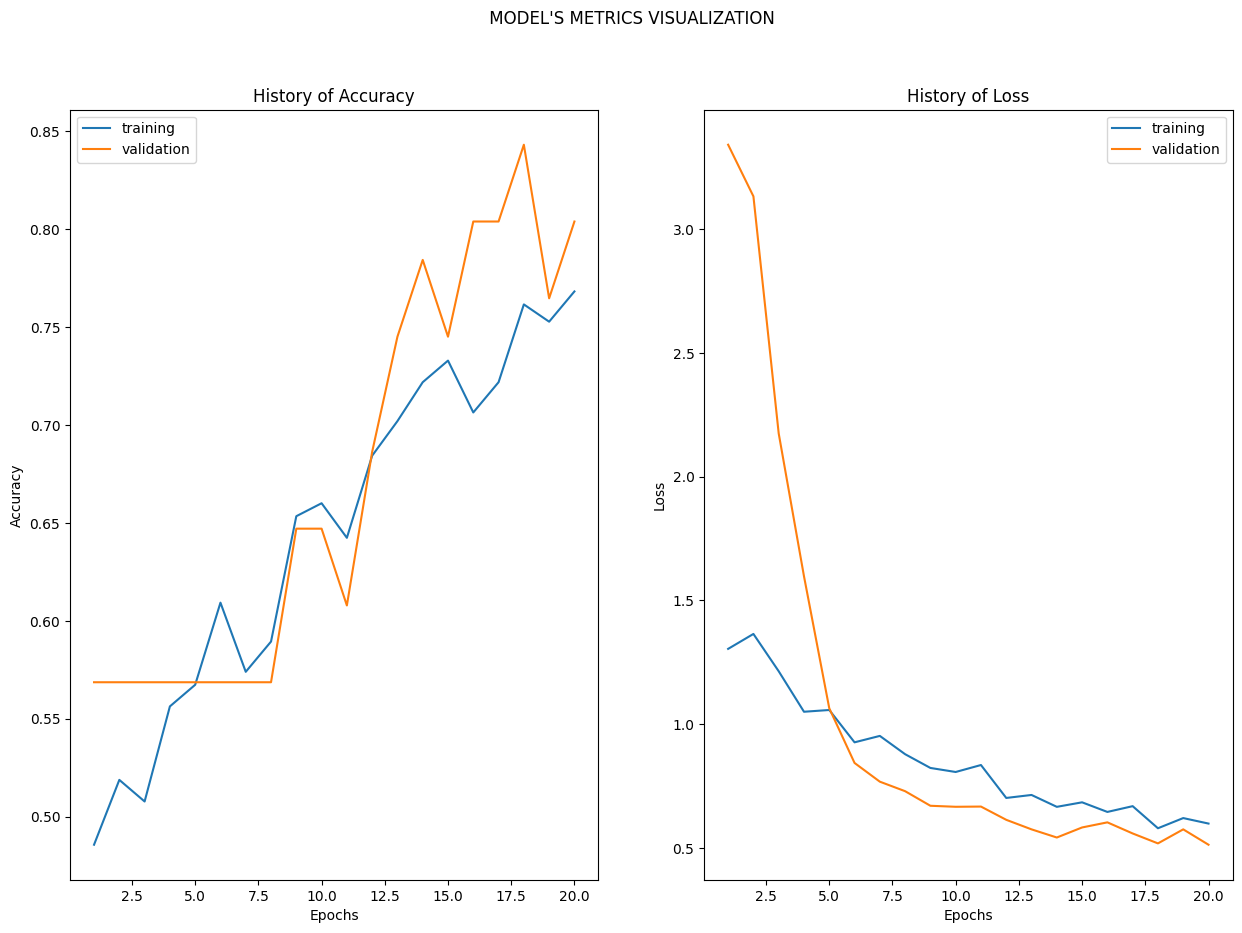

In [24]:
model = resnet()
model.summary()
fit_evaluate(model,X_train,y_train,X_test,y_test,16,20,4)